In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import fashion_mnist
import tensorflow as tf
from keras import models
from keras import layers
from keras import regularizers
from keras.utils import to_categorical
from sklearn.model_selection import KFold
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def pre_processamento():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

    train_images = train_images.reshape((60000,28,28,1))
    train_images = train_images.astype('float32')/255 # Modificar os valores de cada pixel para que eles variem de 0 a 1 melhorará a taxa de aprendizado do nosso modelo.

    test_images = test_images.reshape((10000,28,28,1))
    test_images = test_images.astype('float32')/255 # Modificar os valores de cada pixel para que eles variem de 0 a 1 melhorará a taxa de aprendizado do nosso modelo.

    train_labels = to_categorical(train_labels) # Nosso modelo não pode trabalhar com dados categóricos diretamente. Portanto, devemos usar uma codificação quente. Em uma codificação ativa, os dígitos de 0 a 9 são representados como um conjunto de nove zeros e um único. O dígito é determinado pela localização do número 1. Por exemplo, você representaria um 3 como [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    test_labels = to_categorical(test_labels) # one hot encoding

    return train_images, train_labels, test_images, test_labels

# Definir a arquitetura da MLP
def criar_modelo_mlp(num_neuronios, num_camadas):

    camadas = [num_neuronios] * num_camadas # lista contendo a quantidade de neurônios desejada repetida 'num_camadas'

    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    for neurons in camadas:
        model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def criar_grafico(df, titulo):
    plt.cla()
    plt.plot(df['acuracia'], 'b', marker='.', label='acurácia', linewidth=3, markersize=12)
    plt.title(titulo)
    plt.legend()
    plt.savefig(titulo+".png", format='png', dpi=300, facecolor='white')


Treinando fold 1, com 1 camada(s) oculta, com 25 neurônios
Epoch 1/5
750/750 - 2s - loss: 0.6251 - accuracy: 0.7854 - 2s/epoch - 3ms/step
Epoch 2/5
750/750 - 1s - loss: 0.4520 - accuracy: 0.8397 - 1s/epoch - 2ms/step
Epoch 3/5
750/750 - 1s - loss: 0.4139 - accuracy: 0.8534 - 1s/epoch - 2ms/step
Epoch 4/5
750/750 - 2s - loss: 0.3916 - accuracy: 0.8606 - 2s/epoch - 2ms/step
Epoch 5/5
750/750 - 1s - loss: 0.3748 - accuracy: 0.8669 - 1s/epoch - 2ms/step
375/375 - 1s - loss: 0.3771 - accuracy: 0.8643 - 649ms/epoch - 2ms/step
Treinando fold 2, com 1 camada(s) oculta, com 25 neurônios
Epoch 1/5
750/750 - 2s - loss: 0.6512 - accuracy: 0.7802 - 2s/epoch - 3ms/step
Epoch 2/5
750/750 - 1s - loss: 0.4651 - accuracy: 0.8381 - 1s/epoch - 2ms/step
Epoch 3/5
750/750 - 1s - loss: 0.4285 - accuracy: 0.8501 - 1s/epoch - 2ms/step
Epoch 4/5
750/750 - 1s - loss: 0.4032 - accuracy: 0.8581 - 1s/epoch - 2ms/step
Epoch 5/5
750/750 - 1s - loss: 0.3837 - accuracy: 0.8637 - 1s/epoch - 2ms/step
375/375 - 1s - loss:

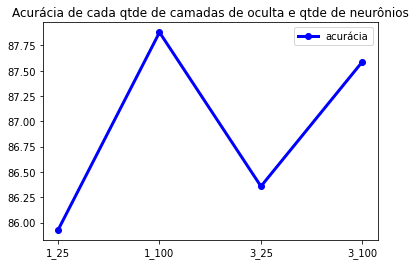

In [3]:
### Main
train_images, train_labels, test_images, test_labels = pre_processamento()


k_folds = 5

cv = KFold(n_splits=k_folds, shuffle=True, random_state=42) # vamos embaralhá-los antes de dividi-lo, seed 42

# --------- Testar diferentes quantidades de camadas e de neurônios ------------
lista_num_camadas = [1, 3]  # Quantidade de neurônios em cada camada
lista_num_neuronios = [25, 100]  # Quantidade de camadas escondidas

dct_camada_neuronio = {}
melhor_acc = 0
melhor_num_camada = 0
melhor_num_neuronio = 0
for num_camadas in lista_num_camadas:
    for num_neuronios in lista_num_neuronios:
        fold_no = 1 #contador
        acc_per_fold = [] #acurácia de cada fold
        for train, test in cv.split(train_images, train_labels): #pra cada fold
            print(f"Treinando fold {fold_no}, com {num_camadas} camada(s) oculta, com {num_neuronios} neurônios" )
            train_X = train_images[train]
            test_X = train_images[test]
            model = criar_modelo_mlp(num_neuronios, num_camadas)
            model.fit(train_X, train_labels[train], epochs=5, batch_size=64, verbose=2)
            test_loss, test_acc = model.evaluate(test_X, train_labels[test], verbose=2)
            acc_per_fold.append(test_acc * 100)
            fold_no = fold_no + 1

        media_acc_camada_neuronio = sum(acc_per_fold)/len(acc_per_fold)

        dct_camada_neuronio.update({str(num_camadas)+"_"+str(num_neuronios): {"acuracia": media_acc_camada_neuronio}})

        print(f"Média acurácia dos 5 folds pra {num_camadas} camada(s) oculta, com {num_neuronios} neurônios:", media_acc_camada_neuronio)
        print(f"Essa acurácia significa que o modelo usando {num_camadas} camada(s) oculta, com {num_neuronios} neurônios, usando a função ReLu para os neurônios das camadas ocultas e SoftMax para a saída é capaz de classificar corretamente em média {round(media_acc_camada_neuronio, 1)}% das imagens")
        if media_acc_camada_neuronio > melhor_acc:
            melhor_acc = media_acc_camada_neuronio
            melhor_num_camada = num_camadas
            melhor_num_neuronio = num_neuronios
print(f"Portanto, a melhor quantidade de camada(s) oculta é {melhor_num_camada}, com {melhor_num_neuronio} neurônios, que possui {round(melhor_acc, 1)} de acurácia.")
dfCamadaNeuronio = pd.DataFrame(dct_camada_neuronio).T
titulo = "Acurácia de cada qtde de camadas de oculta e qtde de neurônios"
criar_grafico(dfCamadaNeuronio, titulo)

In [4]:
melhor_num_camada
melhor_num_neuronio

100

In [5]:
def criar_modelo_mlp_regularizacao(num_neuronios, num_camadas, taxa_regularizacao):

    camadas = [num_neuronios] * num_camadas # lista contendo a quantidade de neurônios desejada repetida 'num_camadas'
    
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    for neurons in camadas:
        model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(taxa_regularizacao)))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Treinando fold 1, com 1 camada(s) oculta, com 100 neurônios e 0.001 de taxa de regularização L2
Epoch 1/5
750/750 - 2s - loss: 0.6956 - accuracy: 0.7985 - 2s/epoch - 3ms/step
Epoch 2/5
750/750 - 1s - loss: 0.5319 - accuracy: 0.8429 - 1s/epoch - 2ms/step
Epoch 3/5
750/750 - 1s - loss: 0.4857 - accuracy: 0.8520 - 1s/epoch - 2ms/step
Epoch 4/5
750/750 - 2s - loss: 0.4595 - accuracy: 0.8592 - 2s/epoch - 2ms/step
Epoch 5/5
750/750 - 2s - loss: 0.4430 - accuracy: 0.8638 - 2s/epoch - 3ms/step
375/375 - 1s - loss: 0.4673 - accuracy: 0.8548 - 909ms/epoch - 2ms/step
Treinando fold 2, com 1 camada(s) oculta, com 100 neurônios e 0.001 de taxa de regularização L2
Epoch 1/5
750/750 - 2s - loss: 0.7068 - accuracy: 0.7987 - 2s/epoch - 3ms/step
Epoch 2/5
750/750 - 1s - loss: 0.5325 - accuracy: 0.8433 - 1s/epoch - 1ms/step
Epoch 3/5
750/750 - 1s - loss: 0.4850 - accuracy: 0.8534 - 1s/epoch - 1ms/step
Epoch 4/5
750/750 - 1s - loss: 0.4607 - accuracy: 0.8573 - 1s/epoch - 1ms/step
Epoch 5/5
750/750 - 1s - 

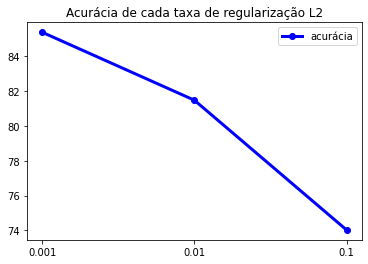

In [6]:
taxas_regularizacao = [0.001, 0.01, 0.1]  # Taxas de regularização L2 a serem testadas

dct_taxa_regularizacao = {}
melhor_acc = 0
melhor_taxa_regularizacao = 0
for taxa_regularizacao in taxas_regularizacao:
        fold_no = 1 #contador
        acc_per_fold = [] #acurácia de cada fold
        for train, test in cv.split(train_images, train_labels): #pra cada fold
            print(f"Treinando fold {fold_no}, com {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios e {taxa_regularizacao} de taxa de regularização L2" )
            train_X = train_images[train]
            test_X = train_images[test]
            model = criar_modelo_mlp_regularizacao(melhor_num_neuronio, melhor_num_camada, taxa_regularizacao)
            model.fit(train_X, train_labels[train], epochs=5, batch_size=64, verbose=2)
            test_loss, test_acc = model.evaluate(test_X, train_labels[test], verbose=2)
            acc_per_fold.append(test_acc * 100)
            fold_no = fold_no + 1

        media_acc_regularizacao = sum(acc_per_fold)/len(acc_per_fold)

        dct_taxa_regularizacao.update({str(taxa_regularizacao): {"acuracia": media_acc_regularizacao}})

        print(f"Média acurácia dos 5 folds pra {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios e {taxa_regularizacao} de taxa de regularização L2:", media_acc_regularizacao)
        print(f"Essa acurácia significa que o modelo usando {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios, com {taxa_regularizacao} de taxa de regularização L2 e usando a função ReLu para os neurônios das camadas ocultas e SoftMax para a saída é capaz de classificar corretamente em média {round(media_acc_regularizacao, 1)}% das imagens")
        if media_acc_regularizacao > melhor_acc:
            melhor_acc = media_acc_regularizacao
            melhor_taxa_regularizacao = taxa_regularizacao
print(f"Portanto, a melhor taxa de regularização L2 é {melhor_taxa_regularizacao}, que possui {round(melhor_acc, 1)} de acurácia.")
dfTaxaRegularizacao = pd.DataFrame(dct_taxa_regularizacao).T
titulo = "Acurácia de cada taxa de regularização L2"
criar_grafico(dfTaxaRegularizacao, titulo)

In [10]:
def criar_modelo_mlp_dropout(num_neuronios, num_camadas, taxa_regularizacao, taxa_dropout):

    camadas = [num_neuronios] * num_camadas # lista contendo a quantidade de neurônios desejada repetida 'num_camadas'
    
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    for neurons in camadas:
        model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(taxa_regularizacao)))
        model.add(layers.Dropout(taxa_dropout))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Treinando fold 1, com 1 camada(s) oculta, com 100 neurônios, 0.001 de taxa de regularização L2 e 0.2 de dropout
Epoch 1/5
750/750 - 3s - loss: 0.7314 - accuracy: 0.7894 - 3s/epoch - 4ms/step
Epoch 2/5
750/750 - 3s - loss: 0.5520 - accuracy: 0.8353 - 3s/epoch - 4ms/step
Epoch 3/5
750/750 - 3s - loss: 0.5068 - accuracy: 0.8454 - 3s/epoch - 4ms/step
Epoch 4/5
750/750 - 3s - loss: 0.4856 - accuracy: 0.8500 - 3s/epoch - 4ms/step
Epoch 5/5
750/750 - 3s - loss: 0.4741 - accuracy: 0.8529 - 3s/epoch - 4ms/step
375/375 - 1s - loss: 0.4499 - accuracy: 0.8596 - 879ms/epoch - 2ms/step
Treinando fold 2, com 1 camada(s) oculta, com 100 neurônios, 0.001 de taxa de regularização L2 e 0.2 de dropout
Epoch 1/5
750/750 - 3s - loss: 0.7327 - accuracy: 0.7857 - 3s/epoch - 3ms/step
Epoch 2/5
750/750 - 2s - loss: 0.5538 - accuracy: 0.8364 - 2s/epoch - 3ms/step
Epoch 3/5
750/750 - 3s - loss: 0.5070 - accuracy: 0.8444 - 3s/epoch - 3ms/step
Epoch 4/5
750/750 - 3s - loss: 0.4859 - accuracy: 0.8497 - 3s/epoch - 4m

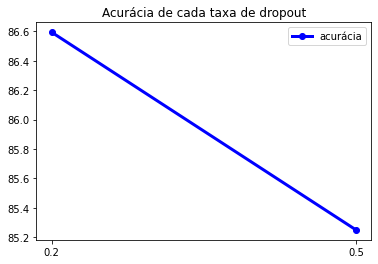

In [11]:
taxas_dropout = [0.2, 0.5]  # Taxas de dropout a serem testadas

dct_taxa_dropout = {}
melhor_acc = 0
melhor_taxa_dropout = 0
for taxa_dropout in taxas_dropout:
        fold_no = 1 #contador
        acc_per_fold = [] #acurácia de cada fold
        for train, test in cv.split(train_images, train_labels): #pra cada fold
            print(f"Treinando fold {fold_no}, com {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios, {melhor_taxa_regularizacao} de taxa de regularização L2 e {taxa_dropout} de dropout" )
            train_X = train_images[train]
            test_X = train_images[test]
            model = criar_modelo_mlp_dropout(melhor_num_neuronio, melhor_num_camada, melhor_taxa_regularizacao, taxa_dropout)
            model.fit(train_X, train_labels[train], epochs=5, batch_size=64, verbose=2)
            test_loss, test_acc = model.evaluate(test_X, train_labels[test], verbose=2)
            acc_per_fold.append(test_acc * 100)
            fold_no = fold_no + 1

        media_acc_dropout = sum(acc_per_fold)/len(acc_per_fold)

        dct_taxa_dropout.update({str(taxa_dropout): {"acuracia": media_acc_dropout}})

        print(f"Média acurácia dos 5 folds pra {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios, {melhor_taxa_regularizacao} de taxa de regularização L2 e {taxa_dropout} de dropout:", media_acc_dropout)
        print(f"Essa acurácia significa que o modelo usando {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios, com {melhor_taxa_regularizacao} de taxa de regularização L2, {taxa_dropout} de dropout e usando a função ReLu para os neurônios das camadas ocultas e SoftMax para a saída é capaz de classificar corretamente em média {round(media_acc_dropout, 1)}% das imagens")
        if media_acc_dropout > melhor_acc:
            melhor_acc = media_acc_dropout
            melhor_taxa_dropout = taxa_dropout
print(f"Portanto, a melhor taxa de dropout é {melhor_taxa_dropout}, que possui {round(melhor_acc, 1)} de acurácia.")
dfDropout = pd.DataFrame(dct_taxa_dropout).T
titulo = "Acurácia de cada taxa de dropout"
criar_grafico(dfDropout, titulo)

In [12]:
augmenter = ImageDataGenerator(
    rotation_range=20, # podem ser rotacionadas aleatoriamente em um ângulo de -20 a 20 graus
    width_shift_range=0.2, # as imagens podem ser deslocadas horizontalmente em até 20% da largura da imagem
    height_shift_range=0.2,  # as imagens podem ser deslocadas verticalmente em até 20% da largura da imagem
    shear_range=0.2, # as imagens podem ser distorcidas com um valor de cisalhamento aleatório entre -0.2 e 0.2
    zoom_range=0.2, # as imagens podem ser ampliadas ou reduzidas em até 20% aleatoriamente.
    horizontal_flip=True # imagens podem ser invertidas horizontalmente durante o data augmentation.
)

dct_dataaug = {}
fold_no = 1 #contador
acc_per_fold = [] #acurácia de cada fol #loss de cada fold
for train, test in cv.split(train_images, train_labels): #pra cada fold
    print(f"Treinando fold {fold_no}, com data augmentation")
    
    # Obter os conjuntos de treinamento e teste para o fold atual
    train_X, test_X = train_images[train], train_images[test]
    train_y, test_y = train_labels[train], train_labels[test]
    
    # Aplicar o data augmentation aos dados de treinamento
    augmenter.fit(train_X)
    augmented_train_X = augmenter.flow(train_X, train_y, batch_size=64)

    model = criar_modelo_mlp_dropout(melhor_num_neuronio, melhor_num_camada, melhor_taxa_regularizacao, melhor_taxa_dropout)

    model.fit(augmented_train_X, epochs=5, validation_data=(test_X, test_y), verbose=2)

    test_loss, test_acc = model.evaluate(test_X, train_labels[test], verbose=2)
    acc_per_fold.append(test_acc * 100)
    fold_no = fold_no + 1

media_acc_dataaug = sum(acc_per_fold)/len(acc_per_fold)

dct_dataaug.update({"acuracia": media_acc_dataaug})

print(f"Média acurácia dos 5 folds com data augmentation:", media_acc_dataaug)
print(f"Essa acurácia significa que o modelo usando {melhor_num_camada} camada(s) oculta, com {melhor_num_neuronio} neurônios, com {melhor_taxa_regularizacao} de taxa de regularização L2, {taxa_dropout} de dropout, com Data Augmentation e usando a função ReLu para os neurônios das camadas ocultas e SoftMax para a saída é capaz de classificar corretamente em média {round(media_acc_dataaug, 1)}% das imagens")
print(f"Portanto, possui em média {round(media_acc_dataaug, 1)} de acurácia.")


Treinando fold 1, com data augmentation
Epoch 1/5
1500/1500 - 17s - loss: 1.4096 - accuracy: 0.5220 - val_loss: 0.9939 - val_accuracy: 0.6828 - 17s/epoch - 11ms/step
Epoch 2/5
1500/1500 - 15s - loss: 1.1745 - accuracy: 0.6004 - val_loss: 0.9005 - val_accuracy: 0.6886 - 15s/epoch - 10ms/step
Epoch 3/5
1500/1500 - 15s - loss: 1.1217 - accuracy: 0.6145 - val_loss: 0.8657 - val_accuracy: 0.7198 - 15s/epoch - 10ms/step
Epoch 4/5
1500/1500 - 15s - loss: 1.1027 - accuracy: 0.6180 - val_loss: 0.8368 - val_accuracy: 0.7079 - 15s/epoch - 10ms/step
Epoch 5/5
1500/1500 - 16s - loss: 1.0890 - accuracy: 0.6233 - val_loss: 0.8127 - val_accuracy: 0.7219 - 16s/epoch - 11ms/step
375/375 - 1s - loss: 0.8127 - accuracy: 0.7219 - 590ms/epoch - 2ms/step
Treinando fold 2, com data augmentation
Epoch 1/5
1500/1500 - 21s - loss: 1.4264 - accuracy: 0.5109 - val_loss: 0.9815 - val_accuracy: 0.6687 - 21s/epoch - 14ms/step
Epoch 2/5
1500/1500 - 18s - loss: 1.1821 - accuracy: 0.5960 - val_loss: 0.8888 - val_accurac

{'acuracia': [87.87999987602234, 85.39000034332275, 86.59333109855652, 71.80166721343994]}


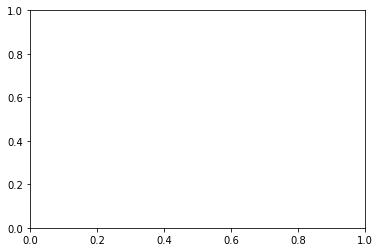

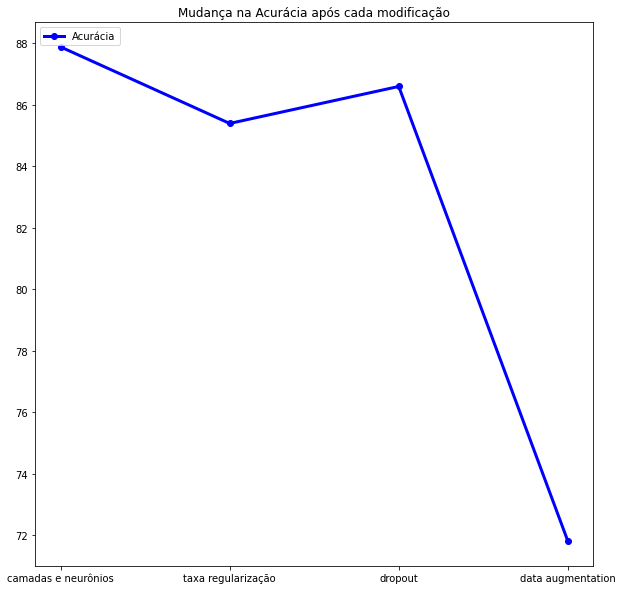

In [14]:
d = {'acuracia':[dct_camada_neuronio[str(melhor_num_camada)+"_"+str(melhor_num_neuronio)]['acuracia'], dct_taxa_regularizacao[str(melhor_taxa_regularizacao)]['acuracia'], dct_taxa_dropout[str(melhor_taxa_dropout)]['acuracia'], dct_dataaug['acuracia']]}
print(d)
dfFinal = pd.DataFrame(data=d, index=['camadas e neurônios','taxa regularização', 'dropout', 'data augmentation'])

plt.cla()
plt.figure(figsize=(10,10)) 
plt.plot(dfFinal, 'b', marker='.', label='Acurácia', linewidth=3, markersize=12)
titulo = "Mudança na Acurácia após cada modificação"
plt.title(titulo)
plt.legend(loc='upper left')
plt.savefig(titulo+".png", format='png', dpi=300, facecolor='white', bbox_inches='tight')